In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import datetime
from bokeh.plotting import figure, show, output_notebook, output_file
output_notebook()

def preprocess(dt):
    dt['week'] = dt['workload'].apply(lambda w: datetime.strptime(w[:w.rfind(".json")], '%Y-%m-%d'))
    
df = pd.read_csv("benchmark.csv")
preprocess(df)

/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


Loading BokehJS ...

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 29 columns):
workload               689 non-null object
makespan               689 non-null float64
std_waitign_time       689 non-null float64
mean_waiting_time      689 non-null float64
mean_slowdown          689 non-null float64
max_waiting_time       689 non-null float64
max_slowdown           689 non-null float64
nb_qos_violations      689 non-null int64
consumed_joules        689 non-null float64
nb_jobs_queue          689 non-null int64
nb_jobs_killed         689 non-null int64
nb_jobs_finished       689 non-null int64
nb_jobs_succeed        689 non-null int64
nb_jobs_rejected       689 non-null int64
nb_switches            689 non-null int64
simulation             689 non-null int64
time_computing         689 non-null float64
time_idle              689 non-null float64
energy_wasted          689 non-null float64
simulation_time        689 non-null float64
mean_idle_time         689 non-n

In [77]:
v = df.groupby(['week', 'policy']).aggregate([np.mean, np.std]).unstack()['energy_wasted'].sort_index()['mean'].reset_index()

base = v[['Timeout (5)']]
print(v)
#diff = (v['DeepShutdown'] - base) / base * 100
#diff > 0

policy       week  DeepShutdown  Timeout (10)  Timeout (15)  Timeout (5)
0      2016-01-03      812466.0     2159460.0     2878212.0    1433304.0
1      2016-01-10     1529319.6     3813024.0     5011116.0    2560224.0
2      2016-01-17     1505350.8     3669288.0     4777320.0    2574480.0
3      2016-01-24      785922.0     2017800.0     2636784.0    1384020.0
4      2016-01-31     1183280.4     2704560.0     3416940.0    1851900.0
5      2016-02-07      523257.6     1160436.0     1514388.0     789960.0
6      2016-02-14     2240426.4     2075520.0     2642016.0    1457700.0
7      2016-02-21     1227220.8     2966856.0     3921576.0    1964244.0
8      2016-02-28     1182654.0     3095784.0     4049352.0    2078940.0
9      2016-03-06     2433423.6     3311076.0     4395180.0    2235516.0
10     2016-03-13     1331217.6     2696508.0     3468804.0    1874640.0
11     2016-03-20      577400.4     1549908.0     2065176.0    1030656.0
12     2016-03-27     1026148.8     2423592.0     3

In [3]:
from bokeh.layouts import gridplot
from math import radians
from bokeh.models.tickers import FixedTicker, DatetimeTicker, SingleIntervalTicker
from bokeh.models.formatters import DatetimeTickFormatter
from bokeh.models import ColumnDataSource, Range1d, DatetimeAxis
from bokeh.palettes import mpl
from bokeh.io import export_png
from bokeh.models import Band, ColumnDataSource, Whisker

colors = mpl['Plasma'][5]

def compare(metric, ylabel, showx=True, legnd=True, compare=True, scale=1):
    grouped = df.groupby(['week', 'policy']).aggregate([np.mean, np.std]).unstack()[metric].sort_index()
    grouped /= scale
    #x = np.array(grouped.index, dtype=np.datetime64)
    x = list(range(0, len(grouped.index)))
    fig = figure(toolbar_location="below", tools='', x_range=(x[0], x[-1] + 0.5), width=900, height=250, x_axis_label='week', y_axis_label=ylabel)
    std = grouped['std']['DeepShutdown']
    fig.line(x, grouped['mean']['DeepShutdown'], legend='DeepShutdown', line_color=colors[0], line_width=1)
    fig.square(x, grouped['mean']['DeepShutdown'], legend='DeepShutdown', line_color=colors[0], fill_color=colors[0], line_width=2)
    if compare:
        fig.line(x, grouped['mean']['idle_5'], legend='Timeout (5)', line_color=colors[1], line_width=1)
        fig.circle(x, grouped['mean']['idle_5'], legend='Timeout (5)', line_color=colors[1], fill_color=colors[1], line_width=2)
        fig.line(x, grouped['mean']['idle_10'], legend='Timeout (10)', line_color=colors[2], line_width=1)
        fig.triangle(x, grouped['mean']['idle_10'], legend='Timeout (10)', line_color=colors[2], fill_color=colors[2], line_width=2)
        fig.line(x, grouped['mean']['idle_15'], legend='Timeout (15)', line_color=colors[3], line_width=1)
        fig.diamond(x, grouped['mean']['idle_15'], legend='Timeout (15)', line_color=colors[3], fill_color=colors[3], line_width=2)
    
    errors = ColumnDataSource({
        'upper':grouped['mean']['DeepShutdown'] + std, 
        'lower': grouped['mean']['DeepShutdown'] - std, 
        'base':x})
    fig.add_layout(Whisker(source=errors, base='base', upper='upper', lower='lower'))
    #band = Band(base='base', lower='lower', upper='upper', source=errors, level='underlay', fill_alpha=0.05, line_width=1, line_color=colors[0], fill_color=colors[0])
    #fig.add_layout(band)
    
    fig.grid.grid_line_alpha = 0
    fig.xaxis.ticker = SingleIntervalTicker(interval=1)
    fig.legend.orientation = "horizontal"
    fig.legend.location = "top_center"
    fig.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks
    fig.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks
    fig.xaxis.visible = showx
    fig.legend.visible = legnd
    return fig
        
p4= compare('mean_preempted_time', 'average delay time (min)', legnd=False, compare=False)
p3 = compare('reward', 'reward', legnd=False, showx=False)
p2 = compare('energy_wasted', 'ernergy Wasted (J x Million)', legnd=False, showx=False, scale=1000000)
p1 = compare('nb_switches', 'nb. of state switches', showx=False)
fig = gridplot([[p1], [p2], [p3], [p4]])
export_png(fig, "weekly.png")
show(fig)
#df.groupby(['week', 'policy']).aggregate([np.mean, np.std]).unstack()['mean_slowdown'].sort_index()['std']

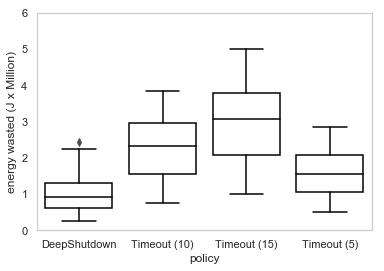

In [341]:
plt.tight_layout()
sns.set_style("whitegrid", {'axes.grid' : False})
grouped = df.groupby(['week', 'policy']).aggregate([np.mean, np.std]).unstack()['energy_wasted'].sort_index()['mean']
grouped = grouped.stack().reset_index()
grouped
ax = sns.boxplot(x='policy', y=0, data=grouped)
ax.set(xlabel='policy', ylabel='energy wasted (J x Million)')
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')

plt.yticks(ax.get_yticks(), np.asarray(ax.get_yticks() / 1000000, np.int))
ax.figure.savefig('energy_wasted.boxplot.png')

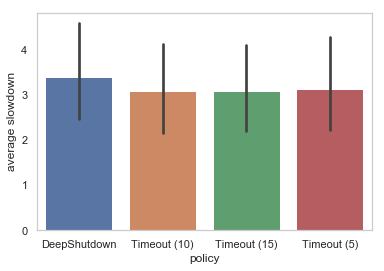

In [348]:
plt.tight_layout()
sns.set_style("whitegrid", {'axes.grid' : False})
grouped = df.groupby(['week', 'policy']).aggregate([np.mean, np.std]).unstack()['mean_slowdown'].sort_index()['mean']
grouped = grouped.stack().reset_index()
grouped
ax = sns.barplot(x='policy', y=0, data=grouped)
ax.set(xlabel='policy', ylabel='average slowdown')
#plt.yticks(ax.get_yticks(), np.asarray(ax.get_yticks() / 1000000, np.int))
ax.figure.savefig('mean_slowdown.barplot.png')

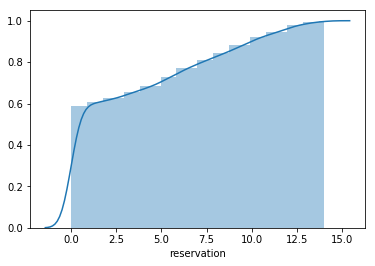

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#df = sns.load_dataset('iris')
 
# No space

df = pd.read_csv('history.csv')
df = df[~((df.queue_sz == 0) & (df.reservation == 0))]
for c in df.cluster.unique():
    data = df[df.cluster == c]
#df = df.groupby(['reservation', 'queue_sz']).queue_sz.count().unstack()#.reset_index(name='freq')
#df.fillna(0, inplace=True)
#df = df.pivot('reservation', 'queue_sz', 'freq')

    sns.distplot(data.reservation,  hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
#sns.heatmap(df, cmap="YlGnBu")
#plt.hist(df.reservation, normed=True, cumulative=True, label='CDF', histtype='step', alpha=0.8, color='k')
plt.show()

/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: Integra

/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: Integra

/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: Integra

/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: Integra

/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/d2/anaconda3/envs/drl-cpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: Integra

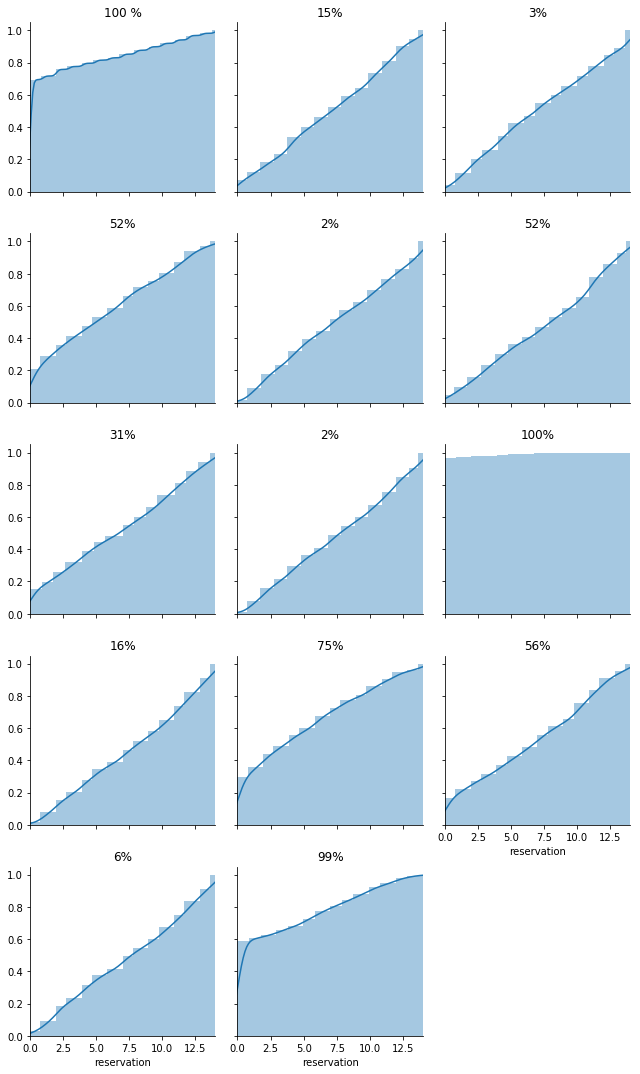

In [8]:

df = pd.read_csv('history.csv')
df = df[~((df.queue_sz == 0) & (df.reservation == 0))]
g = sns.FacetGrid(df, col="cluster", col_wrap=3, xlim=(0, 14)) #, height=2
g.map(sns.distplot, "reservation",  hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
titles = ['100 %', '15%', '3%', '52%', '2%', '52%', '31%', '2%', '100%', '16%', '75%', '56%', '6%', '99%']
for i, ax in enumerate(g.axes):    
    ax.set_title(titles[i])

plt.savefig('')
    